<a href="https://colab.research.google.com/github/MHaley206265/Build-Week-2/blob/master/RaiderIO_scrub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Getting and Engineering DataFrame

In [6]:
mythics_df = pd.read_csv('https://raw.githubusercontent.com/MHaley206265/Build-Week-2/master/mythics_df.csv', index_col=0)
print(mythics.shape)
mythics_df.head(10)

(58883, 25)


,Rank,Dungeon,Level,Time,Affix_1,Affix_2,Affix_3,Affix_4,Tank_Name,Tank_Class,Tank_Link,Heals_Name,Heals_Class,Heals_Link,Dps_1_Name,Dps_1_Class,Dps_1_Link,Dps_2_Name,Dps_2_Class,Dps_2_Link,Dps_3_Name,Dps_3_Class,Dps_3_Link,Score,Faction
0,1,AD,29,00:33:55,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,527.9,horde
1,2,SIEGE,29,01:01:36,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,441.2,horde
2,3,TOS,29,01:02:08,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,439.6,horde
3,4,YARD,28,00:30:25,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,565.3,horde
4,5,YARD,28,00:36:08,10,11,3,120,Andybrew,10,/characters/eu/draenor/Andybrew,Naeniaqt,11,/characters/eu/stormreaver/Naeniaqt,Fanamvp,12,/characters/eu/kazzak/Fanamvp,Lekträh,4,/characters/eu/hyjal/Lekträh,Wildi,8,/characters/eu/draenor/Wildi,558.3,horde
5,6,YARD,28,00:36:14,10,7,12,120,Yönt,1,/characters/eu/drakthul/Yönt,Navve,11,/characters/eu/drakthul/Navve,Agammand,1,/characters/eu/burning-blade/Agammand,Imahottie,8,/characters/eu/drakthul/Imahottie,Micelino,4,/characters/eu/drakthul/Micelino,558.2,horde
6,7,FH,28,00:31:44,10,7,12,120,Nerftank,1,/characters/us/area-52/Nerftank,Ellesmêre,2,/characters/us/area-52/Ellesmêre,Asûna,8,/characters/us/hyjal/Asûna,Imbottom,3,/characters/us/area-52/Imbottom,Jacobxaxa,4,/characters/us/illidan/Jacobxaxa,557.8,horde
7,8,TD,28,00:35:26,10,5,14,120,Nerftank,1,/characters/us/area-52/Nerftank,Ellesmêre,2,/characters/us/area-52/Ellesmêre,Asûna,8,/characters/us/hyjal/Asûna,Imbottom,3,/characters/us/area-52/Imbottom,Jacobxaxa,4,/characters/us/illidan/Jacobxaxa,556.7,horde
8,9,AD,28,00:29:41,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,556.5,horde
9,10,SIEGE,28,00:35:38,10,7,12,120,Nerftank,1,/characters/us/area-52/Nerftank,Ellesmêre,2,/characters/us/area-52/Ellesmêre,Asûna,8,/characters/us/hyjal/Asûna,Imbottom,3,/characters/us/area-52/Imbottom,Jacobxaxa,4,/characters/us/illidan/Jacobxaxa,556.5,horde


## Create Copy of DataFrame

In [7]:
mythics = mythics_df.copy()

## Create new Feature 'Time_Seconds' to display time in seconds

In [8]:
def get_seconds(time):
  h, m, s = [int(i) for i in time.split(':')]

  seconds = (h * 3600) + (m * 60) + (s)

  return seconds

In [9]:
get_seconds('01:30:21')

5421

In [10]:
mythics['Time_Seconds'] = mythics['Time'].apply(get_seconds)

mythics[['Time', 'Time_Seconds']].head()

,Time,Time_Seconds
0,00:33:55,2035
1,01:01:36,3696
2,01:02:08,3728
3,00:30:25,1825
4,00:36:08,2168


## Create feature to show par times for each dungeon

In [11]:
mythics['Dungeon'].unique()

array(['AD', 'SIEGE', 'TOS', 'YARD', 'FH', 'TD', 'UNDR', 'ML', 'WORK',
       'WM', 'SOTS', 'KR'], dtype=object)

In [12]:
def get_par(dungeon):
  par_times = {
    'AD':30,
    'SIEGE':36, 
    'TOS':36, 
    'YARD':38, 
    'FH':36, 
    'TD':36, 
    'UNDR':33, 
    'ML':39, 
    'SOTS':39,
    'WM':39, 
    'WORK':32, 
    'KR':39
  }

  return par_times[dungeon] * 60

In [13]:
mythics['Par_Time'] = mythics['Dungeon'].apply(get_par)

mythics[['Dungeon', 'Par_Time']].head()

,Dungeon,Par_Time
0,AD,1800
1,SIEGE,2160
2,TOS,2160
3,YARD,2280
4,YARD,2280


## Create feature showing team composition

In [14]:
def get_class(class_code):

  class_names = {
      1:'Warrior',
      2:'Paladin',
      3:'Hunter',
      4:'Rogue',
      5:'Priest',
      6:'Death Knight',
      7:'Shaman',
      8:'Mage',
      9:'Warlock',
      10:'Monk',
      11:'Druid',
      12:'Demon Hunter'
  }

  class_title = class_names[class_code]

  return class_title

In [15]:
mythics['Tank_Class_Name'] = mythics['Tank_Class'].apply(get_class)
mythics['Heals_Class_Name'] = mythics['Heals_Class'].apply(get_class)
mythics['Dps_1_Class_Name'] = mythics['Dps_1_Class'].apply(get_class)
mythics['Dps_2_Class_Name'] = mythics['Dps_2_Class'].apply(get_class)
mythics['Dps_3_Class_Name'] = mythics['Tank_Class'].apply(get_class)

mythics.head()

,Rank,Dungeon,Level,Time,Affix_1,Affix_2,Affix_3,Affix_4,Tank_Name,Tank_Class,Tank_Link,Heals_Name,Heals_Class,Heals_Link,Dps_1_Name,Dps_1_Class,Dps_1_Link,Dps_2_Name,Dps_2_Class,Dps_2_Link,Dps_3_Name,Dps_3_Class,Dps_3_Link,Score,Faction,Time_Seconds,Par_Time,Tank_Class_Name,Heals_Class_Name,Dps_1_Class_Name,Dps_2_Class_Name,Dps_3_Class_Name
0,1,AD,29,00:33:55,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,527.9,horde,2035,1800,Warrior,Paladin,Mage,Hunter,Warrior
1,2,SIEGE,29,01:01:36,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,441.2,horde,3696,2160,Warrior,Paladin,Mage,Hunter,Warrior
2,3,TOS,29,01:02:08,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,439.6,horde,3728,2160,Warrior,Paladin,Mage,Hunter,Warrior
3,4,YARD,28,00:30:25,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,565.3,horde,1825,2280,Warrior,Paladin,Mage,Hunter,Warrior
4,5,YARD,28,00:36:08,10,11,3,120,Andybrew,10,/characters/eu/draenor/Andybrew,Naeniaqt,11,/characters/eu/stormreaver/Naeniaqt,Fanamvp,12,/characters/eu/kazzak/Fanamvp,Lekträh,4,/characters/eu/hyjal/Lekträh,Wildi,8,/characters/eu/draenor/Wildi,558.3,horde,2168,2280,Monk,Druid,Demon Hunter,Rogue,Monk


## Make feature for team composition

In [16]:
mythics['Team_Comp'] = mythics['Tank_Class_Name'] + ',' + mythics['Heals_Class_Name'] + ',' + mythics['Dps_1_Class_Name'] + ',' + mythics['Dps_2_Class_Name'] + ',' + mythics['Dps_3_Class_Name']

mythics.head()

,Rank,Dungeon,Level,Time,Affix_1,Affix_2,Affix_3,Affix_4,Tank_Name,Tank_Class,Tank_Link,Heals_Name,Heals_Class,Heals_Link,Dps_1_Name,Dps_1_Class,Dps_1_Link,Dps_2_Name,Dps_2_Class,Dps_2_Link,Dps_3_Name,Dps_3_Class,Dps_3_Link,Score,Faction,Time_Seconds,Par_Time,Tank_Class_Name,Heals_Class_Name,Dps_1_Class_Name,Dps_2_Class_Name,Dps_3_Class_Name,Team_Comp
0,1,AD,29,00:33:55,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,527.9,horde,2035,1800,Warrior,Paladin,Mage,Hunter,Warrior,"Warrior,Paladin,Mage,Hunter,Warrior"
1,2,SIEGE,29,01:01:36,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,441.2,horde,3696,2160,Warrior,Paladin,Mage,Hunter,Warrior,"Warrior,Paladin,Mage,Hunter,Warrior"
2,3,TOS,29,01:02:08,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,439.6,horde,3728,2160,Warrior,Paladin,Mage,Hunter,Warrior,"Warrior,Paladin,Mage,Hunter,Warrior"
3,4,YARD,28,00:30:25,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,565.3,horde,1825,2280,Warrior,Paladin,Mage,Hunter,Warrior,"Warrior,Paladin,Mage,Hunter,Warrior"
4,5,YARD,28,00:36:08,10,11,3,120,Andybrew,10,/characters/eu/draenor/Andybrew,Naeniaqt,11,/characters/eu/stormreaver/Naeniaqt,Fanamvp,12,/characters/eu/kazzak/Fanamvp,Lekträh,4,/characters/eu/hyjal/Lekträh,Wildi,8,/characters/eu/draenor/Wildi,558.3,horde,2168,2280,Monk,Druid,Demon Hunter,Rogue,Monk,"Monk,Druid,Demon Hunter,Rogue,Monk"


In [17]:
# Sort the team comp to lower cardinality

def sort_comp(comp):

  comp_list = comp.split(',')
  comp_list = sorted(comp_list)
  comp=''
  for i in comp_list:
    comp += i

  return comp

In [18]:
mythics['Team_Comp'] = mythics['Team_Comp'].apply(sort_comp)

mythics.head()

,Rank,Dungeon,Level,Time,Affix_1,Affix_2,Affix_3,Affix_4,Tank_Name,Tank_Class,Tank_Link,Heals_Name,Heals_Class,Heals_Link,Dps_1_Name,Dps_1_Class,Dps_1_Link,Dps_2_Name,Dps_2_Class,Dps_2_Link,Dps_3_Name,Dps_3_Class,Dps_3_Link,Score,Faction,Time_Seconds,Par_Time,Tank_Class_Name,Heals_Class_Name,Dps_1_Class_Name,Dps_2_Class_Name,Dps_3_Class_Name,Team_Comp
0,1,AD,29,00:33:55,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,527.9,horde,2035,1800,Warrior,Paladin,Mage,Hunter,Warrior,HunterMagePaladinWarriorWarrior
1,2,SIEGE,29,01:01:36,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,441.2,horde,3696,2160,Warrior,Paladin,Mage,Hunter,Warrior,HunterMagePaladinWarriorWarrior
2,3,TOS,29,01:02:08,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,439.6,horde,3728,2160,Warrior,Paladin,Mage,Hunter,Warrior,HunterMagePaladinWarriorWarrior
3,4,YARD,28,00:30:25,10,7,12,120,Floorpov,1,/characters/eu/tarren-mill/Floorpov,Zmøk,2,/characters/eu/kazzak/Zmøk,Drjaý,8,/characters/eu/kazzak/Drjaý,Gingì,3,/characters/eu/tarren-mill/Gingì,Sebekxd,4,/characters/eu/tarren-mill/Sebekxd,565.3,horde,1825,2280,Warrior,Paladin,Mage,Hunter,Warrior,HunterMagePaladinWarriorWarrior
4,5,YARD,28,00:36:08,10,11,3,120,Andybrew,10,/characters/eu/draenor/Andybrew,Naeniaqt,11,/characters/eu/stormreaver/Naeniaqt,Fanamvp,12,/characters/eu/kazzak/Fanamvp,Lekträh,4,/characters/eu/hyjal/Lekträh,Wildi,8,/characters/eu/draenor/Wildi,558.3,horde,2168,2280,Monk,Druid,Demon Hunter,Rogue,Monk,Demon HunterDruidMonkMonkRogue


# Making Baseline

In [61]:
get_mae(2732)

707.3856630946113

In [58]:
def get_mae(par):
  mean = mythics['Time_Seconds'].describe()[1]
  mae = mean - par
  if mae < 0:
    mae = mae * -1
  return mae

In [ ]:
get_mae(2732)

In [62]:
baseline = mythics['Par_Time'].apply(get_mae)

In [63]:
baseline.describe()

count    58883.000000
mean       197.775394
std         94.268737
min         44.614337
25%        135.385663
50%        135.385663
75%        315.385663
max        315.385663
Name: Par_Time, dtype: float64

# Creating Linear Model

In [19]:
! pip install category_encoders

     |████████████████████████████████| 81kB 5.1MB/s 


In [20]:
from sklearn.linear_model import LinearRegression
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import SCORERS
import plotly.express as px

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
drop_columns=['Rank','Time','Tank_Name','Tank_Link','Heals_Name','Heals_Link',
'Dps_1_Name','Dps_1_Link','Dps_2_Name','Dps_2_Link','Dps_3_Name','Dps_3_Link',
'Score','Time_Seconds','Par_Time', 'Tank_Class_Name', 'Heals_Class_Name',
'Dps_1_Class_Name', 'Dps_2_Class_Name', 'Dps_3_Class_Name']

In [22]:
features = list(mythics.drop(columns=drop_columns).columns)

In [23]:
features

['Dungeon',
 'Level',
 'Affix_1',
 'Affix_2',
 'Affix_3',
 'Affix_4',
 'Tank_Class',
 'Heals_Class',
 'Dps_1_Class',
 'Dps_2_Class',
 'Dps_3_Class',
 'Faction',
 'Team_Comp']

In [24]:
target = 'Time_Seconds'

In [25]:
train, test = train_test_split(mythics, train_size=.8)

In [26]:
train, val = train_test_split(train, train_size=.8)

In [27]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [28]:
pipe = make_pipeline(
    ce.OrdinalEncoder(),
    LinearRegression()
)

In [29]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Dungeon', 'Faction', 'Team_Comp'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Dungeon',
                                          'data_type': dtype('O'),
                                          'mapping': SIEGE     1
KR        2
UNDR      3
AD        4
WORK      5
SOTS      6
WM        7
YARD      8
ML        9
TOS      10
FH       11
TD       12
NaN      -2
dtype: int64},
                                         {'col': 'Faction',
                                          'data_type': dtype('O'),
                                          'mapping': horde...
Demon HunterDruidDruidWarriorWarrior       4
HunterMonkMonkPriestRogue                  5
                                        ... 
ShamanShamanWarlockWarriorWarrior       1571
Death KnightMon

In [30]:
from sklearn.metrics import mean_absolute_error

In [31]:
y_pred = pipe.predict(X_val)

In [32]:
mean_absolute_error(y_val, y_pred)

434.2978986961045

# Make XGBRegressor Model

In [33]:
train, test = train_test_split(mythics, train_size=.8)

In [34]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [35]:
encoder = ce.ordinal.OrdinalEncoder()

X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

In [36]:
param_distributions = { 
    'scale_pos_weight': [1,2,3,4,5,6,7,8,9,10], 
    'max_depth': [2,3,4,5], 
    'learning_rate': uniform(0, 1), 
}

search = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)



In [37]:
search.fit(X_train_enc, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   25.1s finished


[01:01:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=-1, nthread=None,
                                          objective='reg:linear',
                                          random_state=42, reg_alph...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs

In [38]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)

Best hyperparameters {'learning_rate': 0.15599452033620265, 'max_depth': 4, 'scale_pos_weight': 8}
Cross-validation MAE 385.215957064368


In [39]:
xgbr = XGBRegressor(random_state=42, 
                    n_jobs=-1,
                    learning_rate=0.15599452033620265,
                    max_depth=4,
                    scale_pos_weight=8)

eval_set = [(X_train_enc, y_train), (X_test_enc, y_test)]

xgbr.fit(X_train_enc,
         y_train,
         eval_set=eval_set,
         eval_metric='mae',
         early_stopping_rounds=75)

[01:01:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:1710.38	validation_1-mae:1699.18
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 75 rounds.
[1]	validation_0-mae:1443.66	validation_1-mae:1432.84
[2]	validation_0-mae:1218.54	validation_1-mae:1208.08
[3]	validation_0-mae:1028.71	validation_1-mae:1018.57
[4]	validation_0-mae:869.302	validation_1-mae:859.868
[5]	validation_0-mae:737.95	validation_1-mae:729.135
[6]	validation_0-mae:632.586	validation_1-mae:623.662
[7]	validation_0-mae:551.668	validation_1-mae:542.178
[8]	validation_0-mae:492.21	validation_1-mae:482.594
[9]	validation_0-mae:450.096	validation_1-mae:440.456
[10]	validation_0-mae:421.419	validation_1-mae:412.235
[11]	validation_0-mae:402.97	validation_1-mae:394.361
[12]	validation_0-mae:391.436	validation_1-mae:383.228
[13]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.15599452033620265,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=100, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=8,
             seed=None, silent=None, subsample=1, verbosity=1)

In [40]:
xgbr = XGBRegressor(random_state=42, 
                    n_jobs=-1,
                    learning_rate=0.15599452033620265,
                    max_depth=4,
                    scale_pos_weight=8,
                    n_estimators=16,
                    eval_metric='mae')

xgbr.fit(X_train_enc, y_train)

[01:01:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='mae', gamma=0,
             importance_type='gain', learning_rate=0.15599452033620265,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
             n_estimators=16, n_jobs=-1, nthread=None, objective='reg:linear',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=8,
             seed=None, silent=None, subsample=1, verbosity=1)

In [41]:
y_pred = xgbr.predict(X_test_enc)

In [42]:
mean_absolute_error(y_test, y_pred)

369.8226904508324

# Visualizations

In [43]:
importances = xgbr.feature_importances_

In [44]:
imp_df = pd.DataFrame(importances, index=features)
imp_df = imp_df.rename(columns={0:'Values'})
imp_df = imp_df.reset_index()
imp_df = imp_df.rename(columns={'index':'Features'})

In [45]:
imp_df['Features'] = imp_df['Features'].apply(lambda x: x.replace('_', ' '))

In [46]:
imp_df

,Features,Values
0,Dungeon,0.228307
1,Level,0.495364
2,Affix 1,0.028272
3,Affix 2,0.041731
4,Affix 3,0.040407
5,Affix 4,0.000000
6,Tank Class,0.006703
7,Heals Class,0.047041
8,Dps 1 Class,0.006440
9,Dps 2 Class,0.018894


In [47]:
imp_df = imp_df.sort_values(by='Values', ascending=False)

In [48]:
fig = px.bar(imp_df, x='Values', y='Features', orientation='h',
             labels={'Affix_4': 'Affix 4'})
fig.show()

In [49]:
# shapely force plots
! pip install shap

import shap

     |████████████████████████████████| 276kB 9.3MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394129 sha256=3cc019e62a6278ec24b061fbb993a2f120e910b983f289adbab0fae735279e59
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [50]:
sample = list(X_test_enc.sample(1).index)
row = X_test_enc[X_test_enc.index == sample]

explainer = shap.TreeExplainer(xgbr, data=X_test_enc) 

shap_values = explainer.shap_values(row)

display(row)
display(y_test[y_test.index==sample])

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

Passing 11777 background samples may lead to slow runtimes. Consider using shap.sample(data, 100) to create a smaller background data set.


,Dungeon,Level,Affix_1,Affix_2,Affix_3,Affix_4,Tank_Class,Heals_Class,Dps_1_Class,Dps_2_Class,Dps_3_Class,Faction,Team_Comp
2354,2,19,9,11,2,120,1,5,1,9,12,1,582.0


2354    2007
Name: Time_Seconds, dtype: int64

In [51]:
! pip install pdpbox

     |████████████████████████████████| 57.7MB 77kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=460f638afd7b45c4fea30ff3027820a427fb43b77cd318ffebc9686e50c87992
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox


In [52]:
from pdpbox.pdp import pdp_isolate, pdp_plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


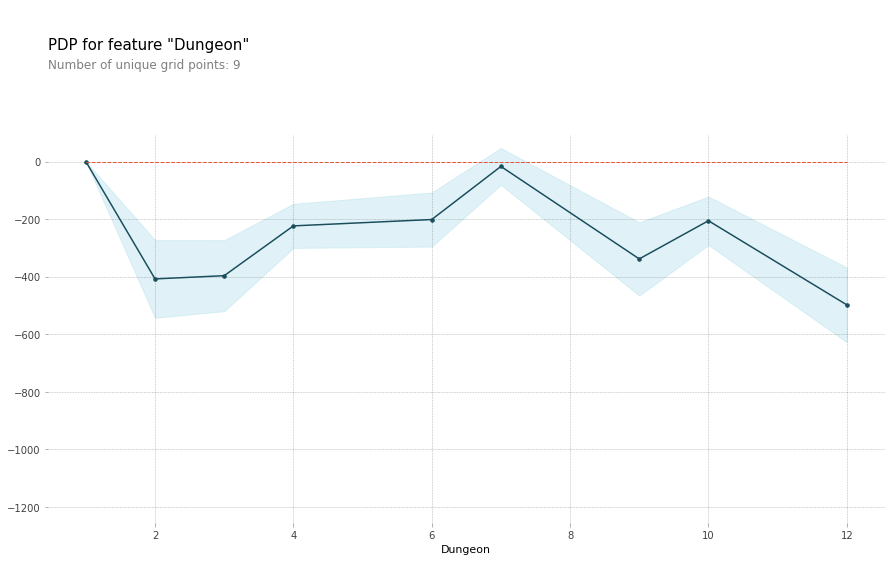

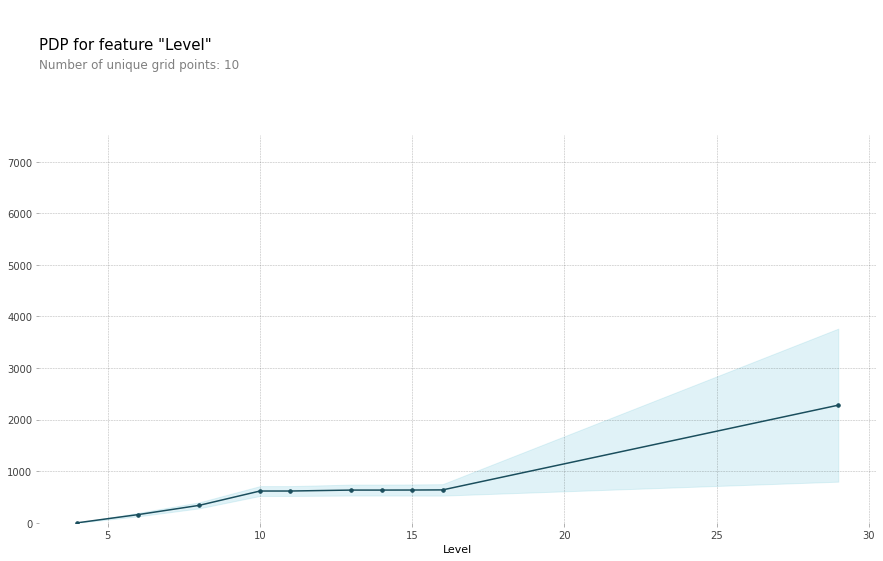

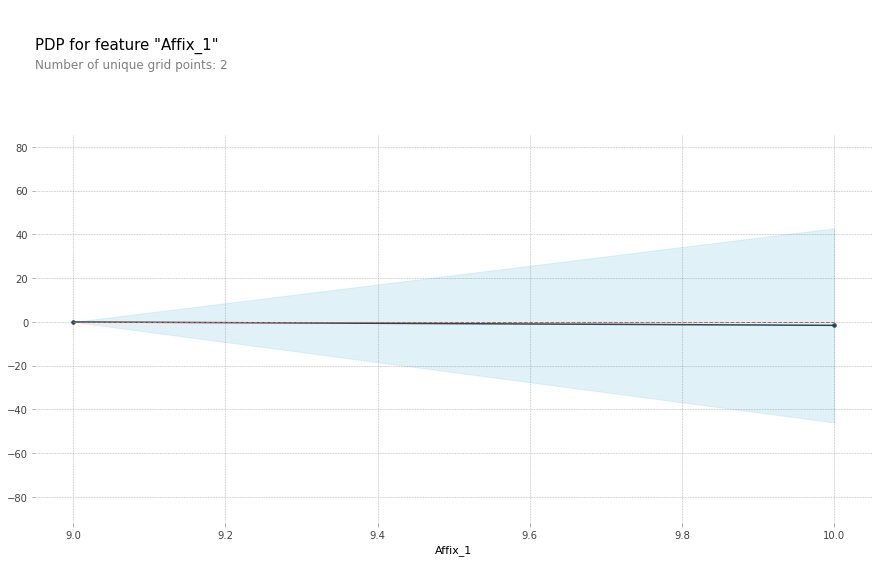

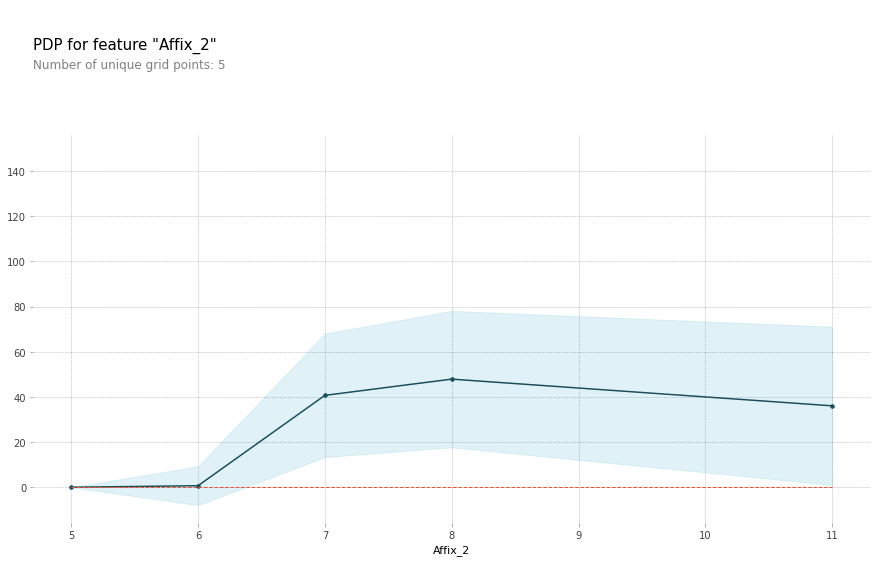

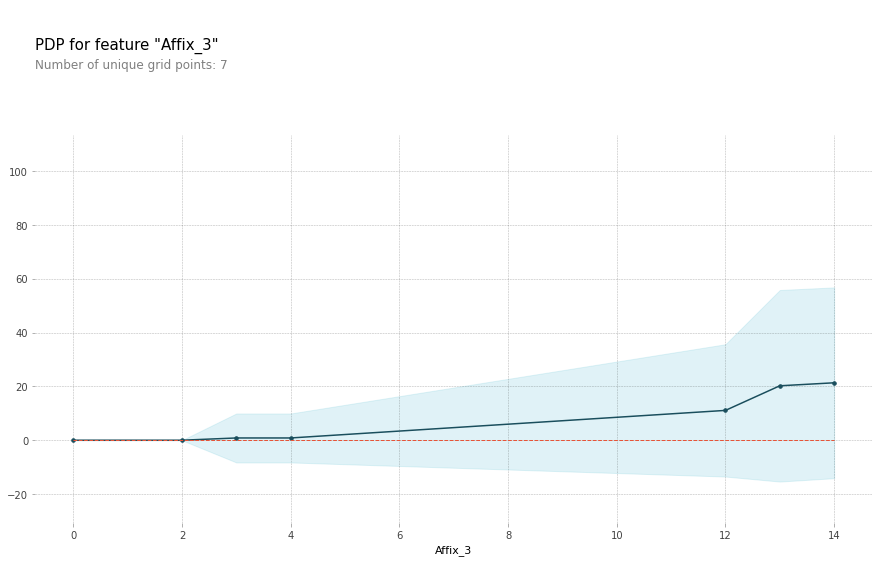

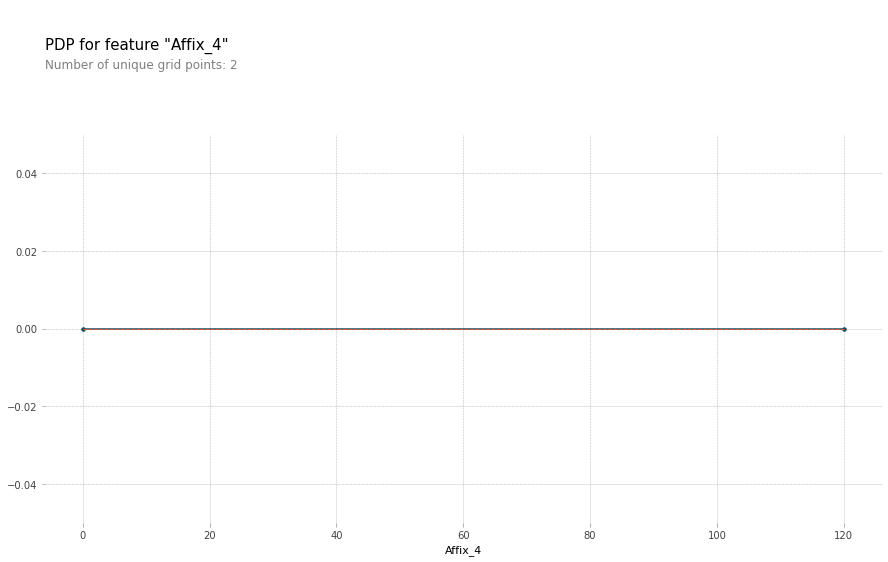

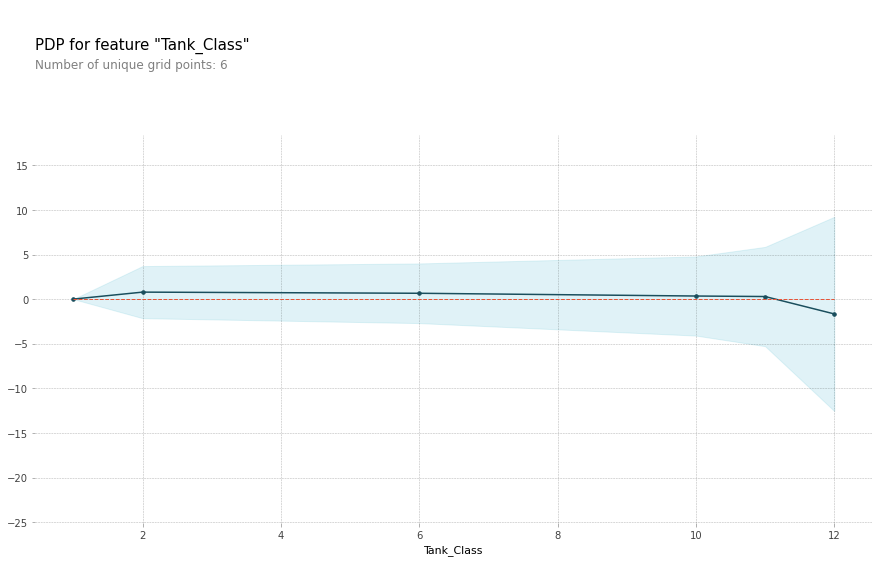

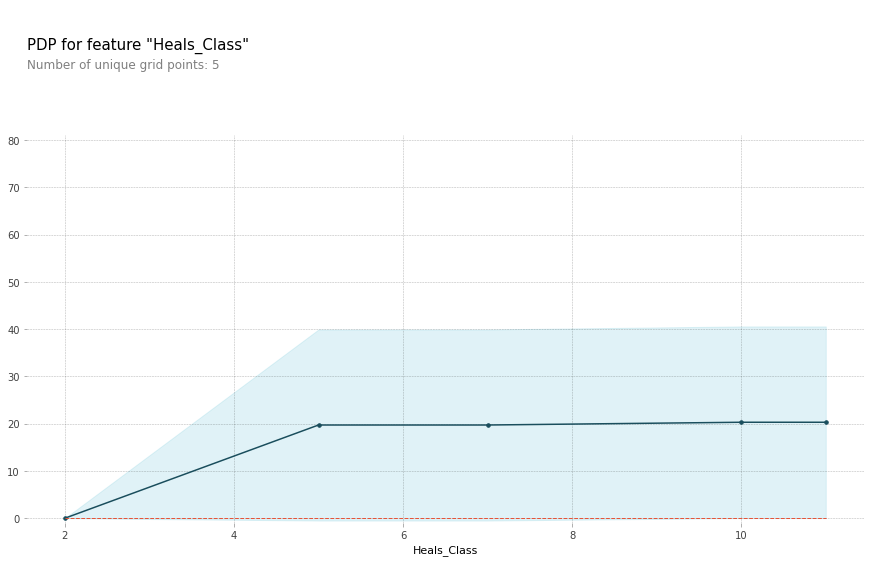

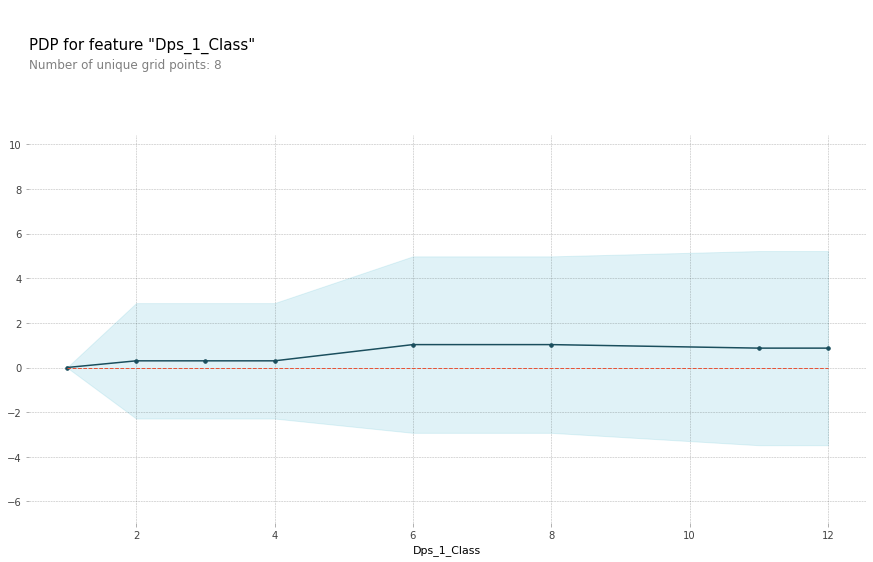

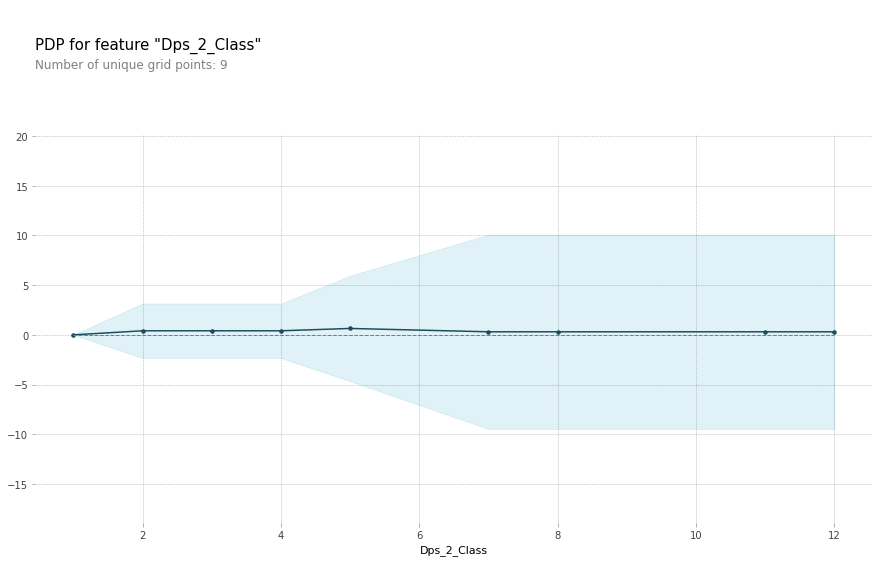

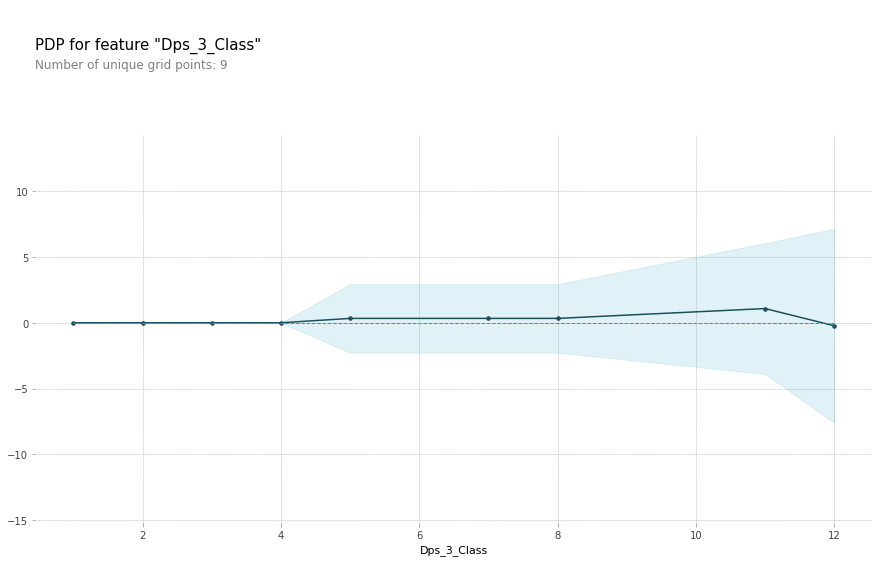

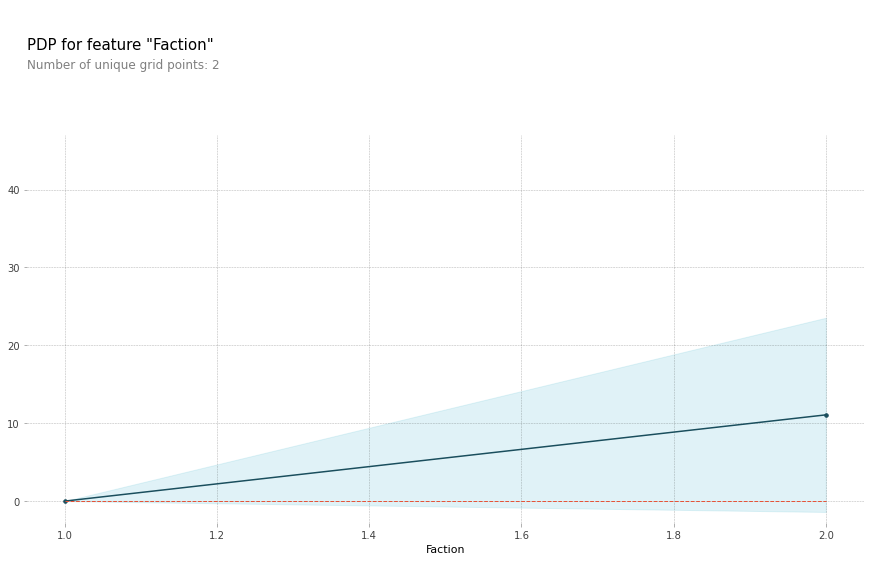

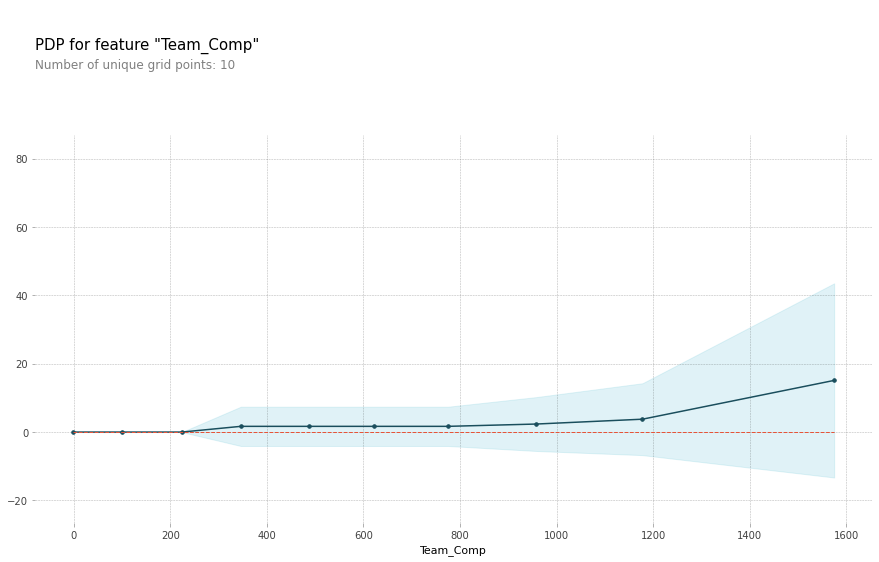

In [53]:
for feature in features:
  isolated = pdp_isolate(
      model=xgbr,
      dataset=X_test_enc,
      model_features=features,
      feature=feature
  )
  pdp_plot(isolated, feature_name=feature)